## Captum 
https://github.com/pytorch/captum

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
from collections import defaultdict

from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
)

In [2]:
class BasicModule(nn.Module):
    def __init__(self):
        super(BasicModule, self).__init__()
        self.model_name = str(type(self))

    def load(self, path):
        self.load_state_dict(torch.load(path))

    def save(self, path):
        torch.save(self.state_dict(), path)

In [3]:
class SimpleCNN(BasicModule):
    def __init__(self,args):
        super(SimpleCNN, self).__init__()
        # output size of fc layers
        out1 = args['fc1_out']
        out2 = args['fc2_out']
        out3 = args['fc3_out'] # output layer
        self.params = args
        self.k = args['k_max']
        
        # self.k = args['k'] # for k max pooling
        self.kernel_num = args['kernel_num']
        self.dropout = nn.Dropout(args['dropout'])
 
        
        # convolution layers
        filter_sizes = [3, 5, 7, 9]
        self.conv1 = nn.Conv2d(1, self.kernel_num[0], (3, 4), bias=True, padding=0)
        self.conv2 = nn.Conv2d(1, self.kernel_num[1], (5, 4), bias=True, padding=0)
        self.conv3 = nn.Conv2d(1, self.kernel_num[2], (7, 4), bias=True, padding=0)
        self.conv4 = nn.Conv2d(1, self.kernel_num[3], (9, 4), bias=True, padding=0)
#         self.conv5 = nn.Conv2d(1, self.kernel_num[4], (11, 4), bias=True, padding=0)

        
        # fc layers
        self.fc1 = nn.Linear((sum([self.kernel_num[i] * (31-filter_sizes[i]) // 2 for i in range(len(filter_sizes))])), out1, bias=True)
        self.fc2 = nn.Linear(out1, out2, bias=True)
        self.fc3 = nn.Linear(out2, out3, bias=False)
        

    def _conv_and_pool(self, x, conv):
        # x: (batch, 1, size, 4)
        x = conv(x)
        # x: (batch, kernel_num, H_out, 1)
        x = F.relu(x)
        # x: (batch, kernel_num, H_out)
        x = F.max_pool2d(x, kernel_size=(2,1), stride=(2, 1))
        x = x.view(x.size(0), x.size(1) * x.size(2))
        #  (batch, kernel_num * k)
        return x
    
    def setDropout(self, dropout):
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: (batch, size)
        # x: (batch, sentence_length, embed_dim)
        x = x.view(x.size(0),1, 30, 4)
        x1 = self._conv_and_pool(x, self.conv1)  # (batch, kernel_num * k)
        x2 = self._conv_and_pool(x, self.conv2)  # (batch, kernel_num * k)
        x3 = self._conv_and_pool(x, self.conv3)  # (batch, kernel_num * k)
        x4 = self._conv_and_pool(x, self.conv4)  # (batch, kernel_num * k)
#         x5 = self._conv_and_pool(x, self.conv5)  # (batch, kernel_num * k)

        
        x = torch.cat((x1, x2, x3, x4), 1)  # (batch, 4 * kernel_num * k)
        x = self.dropout(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
#         x = 
#         logit = F.log_softmax(x, dim=1)
        return self.fc3(x)

In [4]:
class DNADataset(Dataset):
    
    def __init__(self, data, size):
        super(DNADataset, self).__init__()
        self.size = size
        self.x = np.zeros((len(data),size, 4))
        self.y = []

        for I in range(len(data)):
            self.y.append(data[I][1])
            if type(data[0][0])==str:
                for i in range(size):
                    seq = data[I][0].lower()
                    # one hot encoding
                    pos = "acgt".find(seq[i])
                    if pos >= 0:
                        self.x[I][i][pos] = 1
            else:
                self.x[I] = data[I][0]
        self.x = torch.FloatTensor(self.x)
        self.y = torch.FloatTensor(self.y)

        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
        
    # return a subset of dataset of given range
    def get_subset(self, start, end):
        
        return DNADataset([(self.x[i],self.y[i]) for i in range(start, end)], self.size)

In [5]:
#
def load_data(file):
    data = []
    with open(file,"r") as f:
        for line in f:
            line = line.split()
            data.append((line[0], float(line[1])))
    return data

In [6]:
# convert one-hot to GCAT seq
def encoding_to_seq(encoding):
    encoding = encoding.view(-1,4)
    seq = []
    s = 'ACGT'
    for arr in encoding:
        for i in range(4):
            if arr[i] == 1.0:
                seq.append(s[i])
                break
    return seq

In [7]:
#
train_set = DNADataset(load_data("../Cas9_predict_indel/dataset/train_txt"),30)
test_set = DNADataset(load_data("../Cas9_predict_indel/dataset/test_txt"),30)

In [13]:
args = {
    'kernel_num': [100, 100, 80, 60],
    'dropout': 0.5,
    'fc1_out': 80,
    'fc2_out': 60,
    'fc3_out': 1,
    'input_max_length':30,
    'k_max' : 1
}
model = SimpleCNN(args)
model.load("./cnn_3579_100-70-50-40_80-60_90_0.671.model")
model.eval()

SimpleCNN(
  (dropout): Dropout(p=0.5, inplace=False)
  (conv1): Conv2d(1, 100, kernel_size=(3, 4), stride=(1, 1))
  (conv2): Conv2d(1, 100, kernel_size=(5, 4), stride=(1, 1))
  (conv3): Conv2d(1, 80, kernel_size=(7, 4), stride=(1, 1))
  (conv4): Conv2d(1, 60, kernel_size=(9, 4), stride=(1, 1))
  (fc1): Linear(in_features=4320, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=1, bias=False)
)

In [14]:
my_input = test_set[3][0]
ig = IntegratedGradients(model)
baseline = torch.zeros((1,30,4))
model(my_input.view(1,30,4))
attributions = ig.attribute(my_input, baseline, target=0, return_convergence_delta=False)
print('IG Attributions:', attributions)
# print('Convergence Delta:', delta)

IG Attributions: tensor([[[-0.1986,  0.0000,  0.0000, -0.0000],
         [-1.2322,  0.0000,  0.0000, -0.0000],
         [-0.6162,  0.0000,  0.0000, -0.0000],
         [ 0.0000, -0.4308,  0.0000, -0.0000],
         [-0.0000, -0.0000,  0.0000, -0.1690],
         [-0.0000, -0.0000, -0.0000, -0.4861],
         [-0.0000, -0.0000,  2.0566, -0.0000],
         [ 1.1135, -0.0000, -0.0000, -0.0000],
         [-0.0000,  0.0000,  0.7654, -0.0000],
         [ 0.2298, -0.0000, -0.0000, -0.0000],
         [-0.0000,  0.0000,  1.2790, -0.0000],
         [-0.0000,  0.8650,  0.0000, -0.0000],
         [-0.0000,  0.0000,  0.0000, -0.8582],
         [ 0.0000,  0.0000,  0.0000, -3.4994],
         [ 0.0000,  0.0000,  0.0000, -5.2157],
         [-0.0000,  2.5481,  0.0000, -0.0000],
         [-1.4979,  0.0000,  0.0000, -0.0000],
         [-0.0000, -0.0000, -0.0000,  2.1149],
         [ 4.5779, -0.0000,  0.0000, -0.0000],
         [ 3.1421,  0.0000, -0.0000, -0.0000],
         [ 2.2578, -0.0000, -0.0000,  0.000

In [15]:
import seaborn as sns
sns.set_theme()

In [16]:
import pandas as pd

<AxesSubplot:>

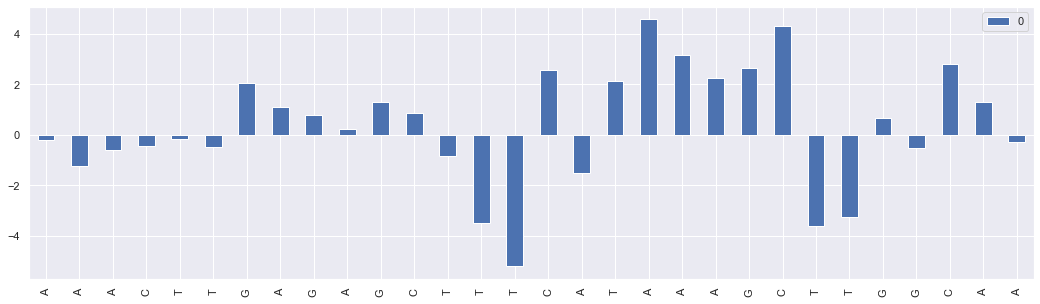

In [17]:
attr = pd.DataFrame([sum(l) for l in attributions.view(30,4).numpy()], index=encoding_to_seq(my_input))
sns.set(sns.set(rc = {'figure.figsize':(18,5)}))
# sns.barplot(attr)
attr.plot(kind='bar')

In [18]:
def show_attr(x, y, method):
    attr = None
    if method == 'IG':
        explainer = IntegratedGradients(model)
        baseline = torch.zeros((1,30,4))
        model(x.view(1,30,4))
        attr = explainer.attribute(x, baseline, target=0, return_convergence_delta=False)
    elif method == 'DL':
        explainer = DeepLift(model)
        baseline = torch.zeros((1,30,4))
        model(x.view(1,30,4))
        attr = explainer.attribute(x, baseline, target=0, return_convergence_delta=False)
    
    attr = pd.DataFrame([sum(l) for l in attr.view(30,4).detach().numpy()], index=encoding_to_seq(x))
    sns.set(sns.set(rc = {'figure.figsize':(18,5)}))
    # sns.barplot(attr)
    attr.plot(kind='bar')
    print(model(x))
    print(y)
    

tensor([[37.5183]], grad_fn=<MmBackward>)
tensor(42.6380)


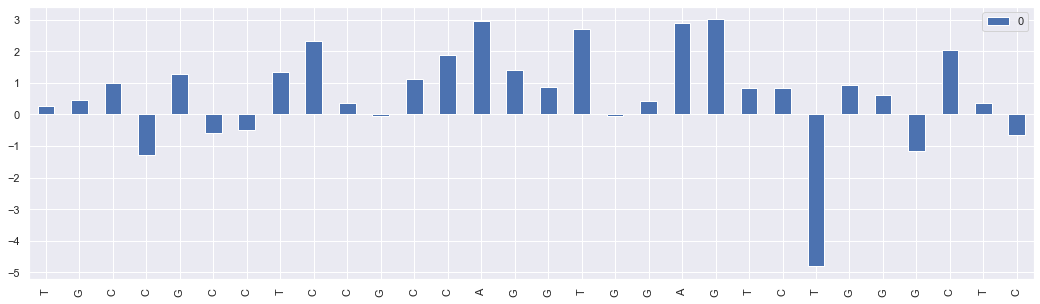

In [19]:
test_case_index = 487
show_attr(test_set[test_case_index][0].view(1,30,4),test_set[test_case_index][1] , method='IG')

tensor([[9.7659]], grad_fn=<MmBackward>)
tensor(10.0362)


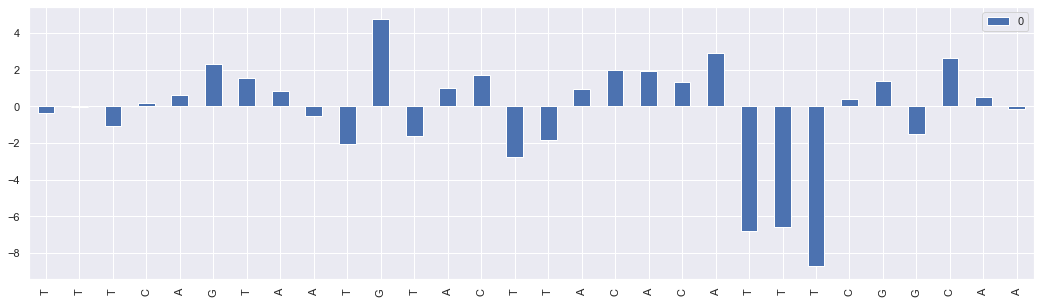

In [26]:
test_case_index = 534
show_attr(test_set[test_case_index][0].view(1,30,4),test_set[test_case_index][1] , method='IG')

tensor([[21.0325]], grad_fn=<MmBackward>)
tensor(24.8673)


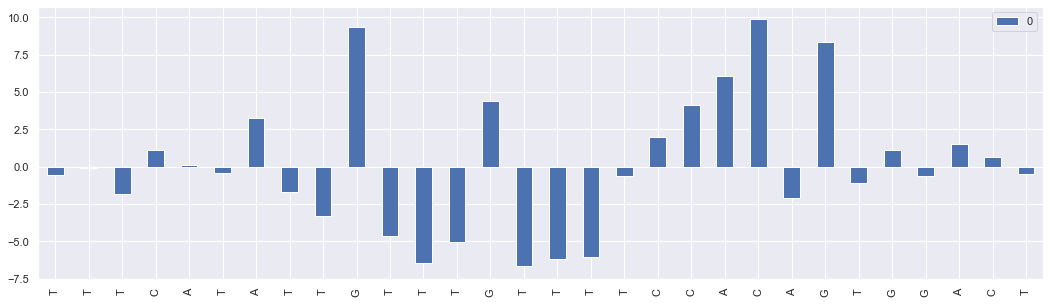

In [27]:
test_case_index = 535
show_attr(test_set[test_case_index][0].view(1,30,4),test_set[test_case_index][1] , method='IG')

tensor([[24.0367]], grad_fn=<MmBackward>)
tensor(10.0362)


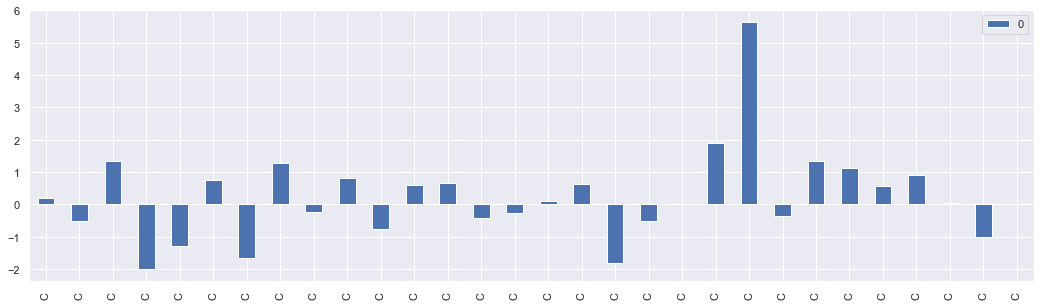

In [40]:
A = [1,0,0,0]
C = [0,1,0,0]
G = [0,0,1,0]
T = [0,0,0,1]
N = [0.25,0.25,0.25,0.25]
test_case_index = 534
show_attr(torch.FloatTensor([C]*30).view(1,30,4),test_set[test_case_index][1] , method='IG')

In [29]:
[[0,0,1,0]]*2

[[0, 0, 1, 0], [0, 0, 1, 0]]